# Basics of Annotation Vectors

This tutorial is the first part of a two-part series of tutorials. It summarizes the findings of the [Matrix Profile V](https://www.cs.ucr.edu/~eamonn/guided-motif-KDD17-new-format-10-pages-v005.pdf) paper and replicates presented case studies.

In the [Matrix Profile I](https://www.cs.ucr.edu/~eamonn/PID4481997_extend_Matrix%20Profile_I.pdf) paper and the [STUMPY Basics](https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html) tutorial we have explored the discovery of time series motifs using the matrix profile. Time series motifs, as described in the STUMPY Basics tutorial, are approximately repeated subsequences within a time series. While the concept of motif discovery is crucial to many fields and practical applications, the process of motif discovery isn't usually as clean in the real world as we would like it to be. In most practical uses of motif discovery, we find some motifs to be more desirable than others.

Consider, for instance, the [Amazon Customer Reviews Dataset](https://www.kaggle.com/bittlingmayer/amazonreviews) which contains several million customer reviews from Amazon's website. If we were to combine all the textual reviews to reveal the most used words on the platform, we would, unsurprisingly, find the word "Amazon" to be around the top of the list, probably following a few other more commonly used words, such as "the", "and" and "is". While this result is obvious, it is certainly not useful. In order to produce more insightful results, we would need to filter this dataset to exclude less interesting, or "[stop words](https://en.wikipedia.org/wiki/Stop_word)", and make way for the more interesting ones.

When it comes to motif discovery, we use a similar approach. While we can't "filter" a time series, we can incentivize the identification of more interesting motifs and penalize that of the less interesting ones. This tutorial will provide a brief introduction to **Guided Motif Search** and **Annotation Vectors**, arrs well as their use cases in the context of tackling **Actionability Bias.** The second tutorial of this two-part series, [Advanced Annotation Vectors](https://stumpy.readthedocs.io/en/latest/Tutorial_Advanced_Annotation_Vectors.html), will cover the application of annotation vectors in addressing **Stop-Word Motif Bias** and **Simplicity Bias.**

## Getting Started

Let’s import the packages that we’ll need to load, analyze, and plot the data.

In [116]:
%matplotlib inline

import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from stumpy import stump

plt.style.use('stumpy.mplstyle')

## What are Annotation Vectors

An annotation vector is a time series that highlights the "importance" of subsequences of another time series. It is usually a vector of real-valued numbers between 0 and 1, with 0 indicating an undesirable motif and 1 indicating a desirable one.

Consider the [Dodgers Loop Sensor Dataset](https://archive.ics.uci.edu/ml/datasets/Dodgers+Loop+Sensor) contains traffic data from Glendale, Los Angeles.

In [117]:
# TO-DO: clean this up after pre-processed dataset is uploaded to Zenodo
dodgers_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/event-detection/Dodgers.data', header=None)

dodgers_df.columns = ['DateTime', 'Count']
dodgers_df = dodgers_df[dodgers_df.Count != -1]

dodgers_df[['Date', 'Time']] = dodgers_df['DateTime'].str.split(' ', expand=True)
dodgers_df = dodgers_df.drop('DateTime', 1)

dodgers_df[['Hour', 'Minute']] = dodgers_df['Time'].str.split(':', expand=True)
dodgers_df = dodgers_df.drop('Time', 1)

dodgers_df[['Month', 'Day', 'Year']] = dodgers_df['Date'].str.split('/', expand=True)
dodgers_df = dodgers_df.drop('Date', 1)

dodgers_df = dodgers_df[['Minute', 'Hour', 'Day', 'Month', 'Year', 'Count']]
dodgers_df.head()

,Minute,Hour,Day,Month,Year,Count
379,35,7,11,4,2005,23
380,40,7,11,4,2005,42
381,45,7,11,4,2005,37
382,50,7,11,4,2005,24
383,55,7,11,4,2005,39


The dataset provides the number of cars detected at regular intervals throughout the day. We can certainly obtain the matrix profile of this time series and extract motifs.

But what if we only want motifs from the morning, and ignore the data from all other times? In cases like this, where we need to exclude or tone down certain parts of the time series, we build an annotation vector. We can consider morning time to be between 5 AM and 12 AM and construct an annotation vector that is 1 during the that time and 0 otherwise:

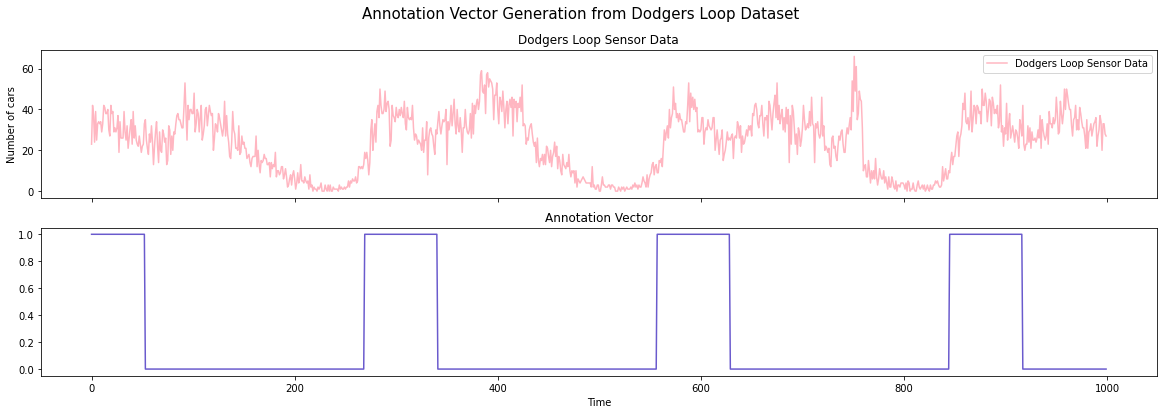

In [118]:
dodgers_count = np.array(dodgers_df['Count']).astype(np.uint16)
dodgers_hour = np.array(dodgers_df['Hour']).astype(np.uint8)

annotation_vector = (dodgers_hour > 5) & (dodgers_hour < 12).astype(np.uint8)

fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('Annotation Vector Generation from Dodgers Loop Dataset', fontsize='15')

axis[0].plot(dodgers_count[:1000], color='lightpink', label='Dodgers Loop Sensor Data')
axis[0].legend()
axis[0].set_ylabel('Number of cars')
axis[0].set_title('Dodgers Loop Sensor Data')

axis[1].plot(annotation_vector[:1000], color='slateblue', label='Annotation Vector')
axis[1].set_xlabel('Time')
axis[1].set_title('Annotation Vector')

plt.show()

We can then combine this annotation vector with the matrix profile to formulate a **Corrected Matrix Profile** which we can use to identify our desirable motifs. The corrected matrix profile can be acquired using the following formula:

$$
\begin{align*}
CMP[i] &= MP[i] + (1 - AV[i]) \times max(MP)
\end{align*}
$$

$CMP$ is the corrected matrix profile, $MP$ is the original matrix profile, $AV$ is the annotation vector and $max(MP)$ is the maximum value of the original matrix profile. We will demonstrate the use of this formula in the case studies below.

## Actionability Bias

**Actionability Bias** refers to the greater actionability or exploitability of certain data subsets than others. In other words, certain subsequences are more interesting than others. In the Dodgers Loop Sensor Dataset, we assigned more importance to the data collected during the morning, making that data more actionable and useful than the data from the rest of the day. The actionability patterns of subsequences of a dataset is certainly dependent on the context and are generally arbitrary.

### Suppressing Motion Artifact

In order to introduce actionability bias in our motif search, we can construct an annotation vector based on desirable and undesirable time series subsequences. In many cases, the undesirability of some subsquences is absolute. In other words, we want to completely disable some regions in the time series from being considered for our motif search. This was the case in the Dodgers Loop dataset example, where we only wanted to focus on the data between 5 AM and 12 AM, and so in that interval, the annotation vector was 1. In all other intervals, the annotation vector was 0. There was no in-between.

Consider the [fNIRS brain imaging dataset](https://drive.google.com/file/d/0B1ZwONZKxJgTa2lFdDMtTnZMTUU/view?usp=sharing) produced by the UCLA Medical Center. **fNIRS**, or **functional near-infrared specroscopy** is an optical imaging technique that is used to measure hemoglobin concentrations throughout the brain. We can download this directly from [Google Drive](https://drive.google.com/file/d/0B1ZwONZKxJgTa2lFdDMtTnZMTUU/view?usp=sharing), or use `gdown`.

In [119]:
# TO-DO: Replace this with pd.read_csv() once dataset is uploaded to Zenodo
!pip3 install gdown
!gdown https://drive.google.com/uc?id=0B1ZwONZKxJgTa2lFdDMtTnZMTUU

You are using pip version 18.1, however version 21.1.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Downloading...
From: https://drive.google.com/uc?id=0B1ZwONZKxJgTa2lFdDMtTnZMTUU
To: C:\Users\zzaman\Documents\personal\STUMPY\AnnotationVectors\fNIRS_subLen_600.mat

  0%|          | 0.00/231k [00:00<?, ?B/s]
100%|##########| 231k/231k [00:00<00:00, 855kB/s]
100%|##########| 231k/231k [00:00<00:00, 809kB/s]


In [120]:
dataset = loadmat('fNIRS_subLen_600.mat')

fNIRS_data = dataset['data'][0]
acc_data = dataset['data'][1]

df = {
    'fNIRS Data': fNIRS_data,
    'Sensor Acceleration': acc_data,
}

df = pd.DataFrame(df)
df.head()

,fNIRS Data,Sensor Acceleration
0,4999,8105
1,4998,7959
2,4998,8057
3,5000,7959
4,5003,8008


The dataset contains two columns: the fNIRS data and the sensor acceleration data, the latter of which we will get to later. In order to simplify the demonstration, we will be working with a smaller subset of the dataset.

In [121]:
fNIRS_data = fNIRS_data[6000:14000].astype(np.float64)
acc_data = acc_data[6000:14000].astype(np.float64)

We can use the `stump` function from STUMPY to compute the matrix profile of this time series and identify the nearest neighbor motifs.

In [122]:
def getMotifData(data, matrix_profile, window_size):
    motif_index = np.argmin(matrix_profile[:, 0])
    motif_x = np.arange(motif_index, motif_index + window_size)
    motif_y = data[motif_index:motif_index + window_size]
    motif = (motif_index, motif_x, motif_y)

    neighbor_index = matrix_profile[motif_index, 1]
    neighbor_x = np.arange(neighbor_index, neighbor_index + window_size)
    neighbor_y = data[neighbor_index:neighbor_index + window_size]
    neighbor = (neighbor_index, neighbor_x, neighbor_y)
    
    return motif, neighbor

In [123]:
window_size = 600
matrix_profile = stump(fNIRS_data, window_size)
motif1, motif2 = getMotifData(fNIRS_data, matrix_profile, window_size)

print(f'Minimum Z-Normalized Euclidean Distance Between 2 Subsequences: {matrix_profile[motif1[0]][0]}')
print(f'Starting Indices of Motifs: {motif1[0]}, {motif2[0]}')

Minimum Z-Normalized Euclidean Distance Between 2 Subsequences: 4.1063461123005505
Starting Indices of Motifs: 3995, 5995


Now that we know the locations of the motifs, we can visualize them.

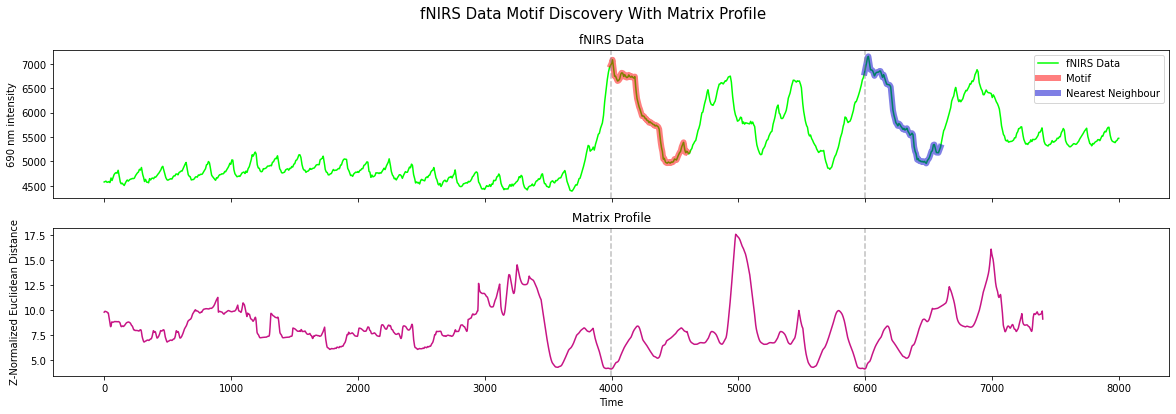

In [124]:
fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('fNIRS Data Motif Discovery With Matrix Profile', fontsize='15')

axis[0].plot(fNIRS_data, color='lime', label='fNIRS Data')
axis[0].plot(motif1[1], motif1[2], color='red', linewidth=6, alpha=0.5, label='Motif')
axis[0].plot(motif2[1], motif2[2], color='mediumblue', linewidth=6, alpha=0.5, label='Nearest Neighbour')
axis[0].legend()
axis[0].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[0].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[0].set_ylabel('690 nm intensity')
axis[0].set_title('fNIRS Data')

axis[1].plot(matrix_profile[:, 0], color='mediumvioletred', label='Matrix Profile')
axis[1].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[1].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Z-Normalized Euclidean Distance')
axis[1].set_title('Matrix Profile')

plt.show()

Without further context, the results look like exactly what we want. The two subsequences identified are, in fact, the closest matches.

Now, in order to provide context for this data, we introduce the sensor acceleration dataset, which includes the acceleration data of the sensor worn by the test subject.

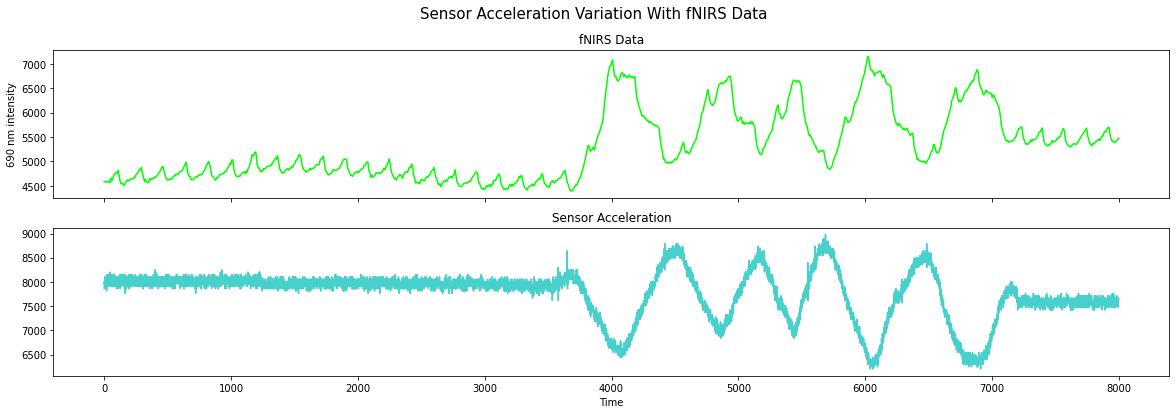

In [125]:
fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('Sensor Acceleration Variation With fNIRS Data', fontsize='15')

axis[0].plot(fNIRS_data, color='lime', label='fNIRS Data')
axis[0].set_ylabel('690 nm intensity')
axis[0].set_title('fNIRS Data')

axis[1].plot(acc_data, color='mediumturquoise', label='Sensor Acceleration')
axis[1].set_xlabel('Time')
axis[1].set_title('Sensor Acceleration')

plt.show()

The sensor acceleration data reveals rapid movement between the 4000 and 7000 marks. But what does this mean? Why do we care?

This simply means that the fNIRS data collected during this region has no medical significance. What the brain imaging sensor was picking up during this interval was simply the variation in infrared radiation caused by the physical movement of the test subject and not by the hemoglobin concentrations of the brain.

So, given this data, how do we rule out these intervals? How do we produce an annotation vector from this time series?

We do this by monitoring the variations in the sensor acceleration. We start by computing the sliding standard deviation of the acceleration data. This gives us the standard deviation vector of the subsequences of this time series. We then compute the overall mean of the standard deviation vector and compare the sliding standard deviation to the mean at different parts of the time series.

If at any point in the time series, the local standard deviation is greater than the mean of the standard deviation vector, this indicates a region of physical movement, and so the annotation vector of this region should be 0. Similarly, if the local standard deviation is less than the mean of the standard deviation vector, this indicates a region that's possibly free from physical movement, so we annotate this region to a 1 in the annotation vector.

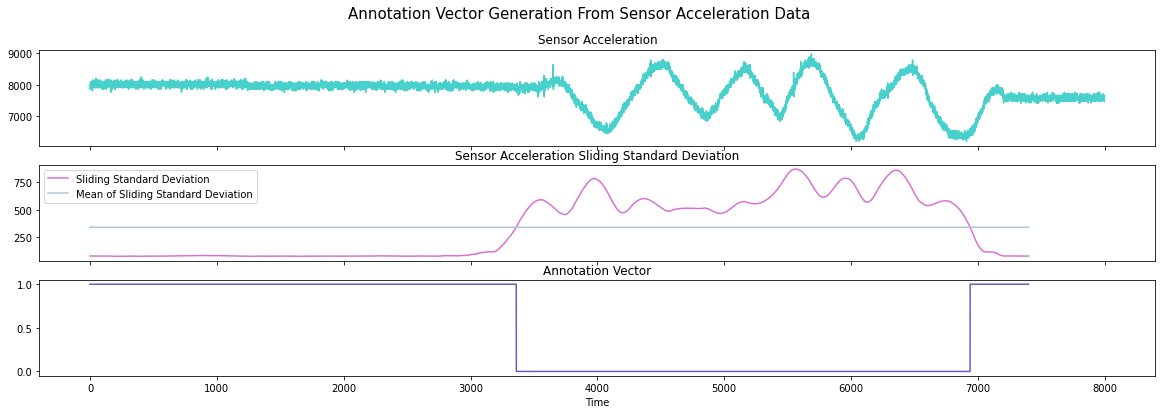

In [126]:
acc_stdev = pd.Series(acc_data).rolling(window_size).std()
acc_stdev = np.array(acc_stdev[window_size - 1:])

acc_stdev_mean = np.mean(acc_stdev)
acc_stdev_mean_series = np.full(np.shape(acc_stdev)[0], acc_stdev_mean)

annotation_vector = (acc_stdev < acc_stdev_mean).astype(np.uint8)

fig, axis = plt.subplots(3, sharex=True)
plt.suptitle('Annotation Vector Generation From Sensor Acceleration Data', fontsize='15')

axis[0].plot(acc_data, color='mediumturquoise', label='Sensor Acceleration')
axis[0].set_title('Sensor Acceleration')

axis[1].plot(acc_stdev, color='orchid', label='Sliding Standard Deviation')
axis[1].plot(acc_stdev_mean_series, color='lightsteelblue', label='Mean of Sliding Standard Deviation')
axis[1].legend()
axis[1].set_title('Sensor Acceleration Sliding Standard Deviation')

axis[2].plot(annotation_vector, color='slateblue', label='Annotation Vector')
axis[2].set_xlabel('Time')
axis[2].set_title('Annotation Vector')

plt.show()

Now we have an annotation vector that we can use to rule out the regions of physical movement. We can use the formula introduced earlier to compute the corrected matrix profile.

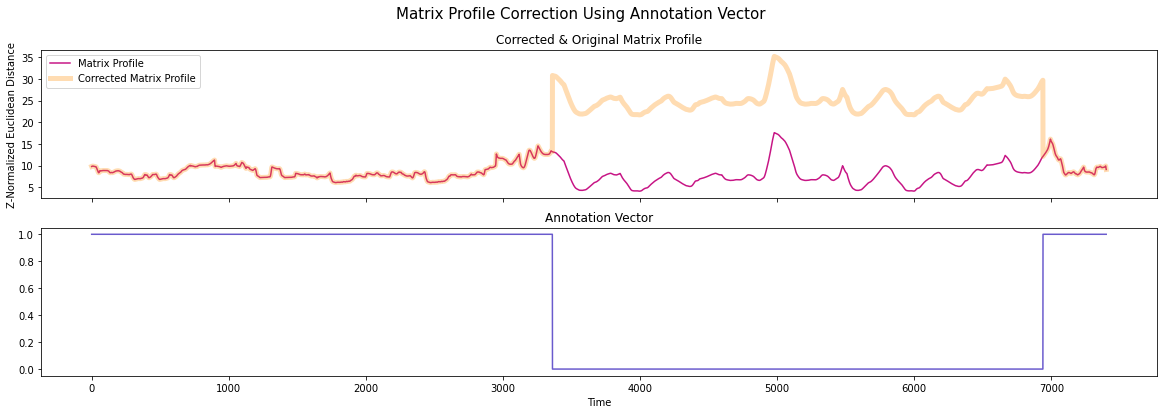

In [127]:
corrected_matrix_profile = matrix_profile[:, 0] + ((1 - annotation_vector) * np.amax(matrix_profile[:, 0]))
corrected_matrix_profile = np.column_stack((corrected_matrix_profile, matrix_profile[:, [1, 2, 3]]))
motif1, motif2 = getMotifData(fNIRS_data, corrected_matrix_profile, window_size)

fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('Matrix Profile Correction Using Annotation Vector', fontsize='15')

axis[0].plot(matrix_profile[:, 0], color='mediumvioletred', label='Matrix Profile')
axis[0].plot(corrected_matrix_profile[:, 0], color='darkorange', linewidth=5, alpha=0.3, label='Corrected Matrix Profile')
axis[0].set_ylabel('Z-Normalized Euclidean Distance')
axis[0].set_title('Corrected & Original Matrix Profile')
axis[0].legend(loc ='upper left')

axis[1].plot(annotation_vector, color='slateblue', label='Annotation Vector')
axis[1].set_xlabel('Time')
axis[1].set_title('Annotation Vector')

plt.show()

As we can see, the corrected matrix profile is elevated around the region of physical movement. This is done to penalize this region. The lowest point in the matrix profile is no longer in the interval where the test subject physically moves. Now we can test the performance of this corrected matrix profile in locating our desirable motifs.

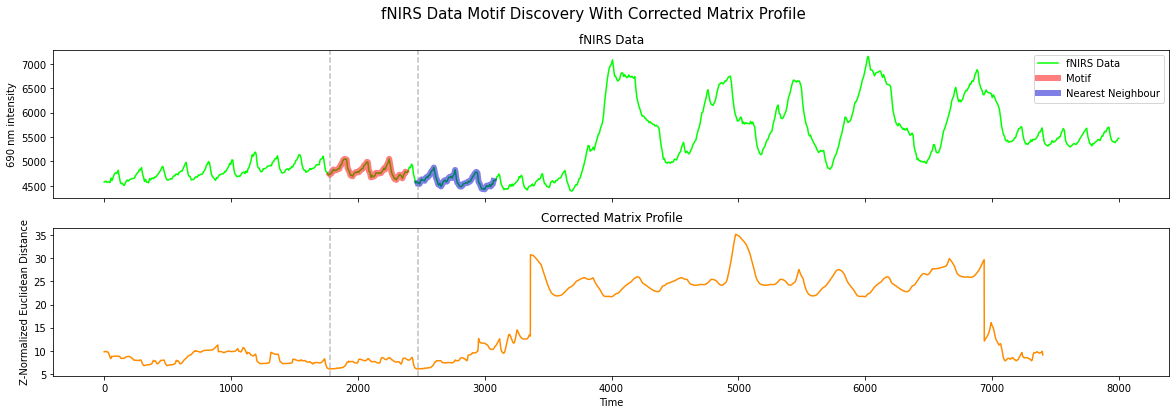

In [128]:
fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('fNIRS Data Motif Discovery With Corrected Matrix Profile', fontsize='15')

axis[0].plot(fNIRS_data, color='lime', label='fNIRS Data')
axis[0].plot(motif1[1], motif1[2], color='red', linewidth=6, alpha=0.5, label='Motif')
axis[0].plot(motif2[1], motif2[2], color='mediumblue', linewidth=6, alpha=0.5, label='Nearest Neighbour')
axis[0].legend()
axis[0].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[0].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[0].set_ylabel('690 nm intensity')
axis[0].set_title('fNIRS Data')

axis[1].plot(corrected_matrix_profile[:, 0], color='darkorange', label='Matrix Profile')
axis[1].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[1].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Z-Normalized Euclidean Distance')
axis[1].set_title('Corrected Matrix Profile')

plt.show()

As we can see, the nearest neighbor pairs have moved towards the left near the smaller peaks that correspond to more desirable data. We have successfully excluded the region of physical movement from our motif search.

In this example we have produced an annotation vector that completely neglects our undesirable region. There are cases, however, when we don't want to completely remove a region from the motif search, but merely "discourage" it. The next example explores this case.

### Suppressing Hard-Limited Artifacts

Consider the [EOG dataset](https://drive.google.com/file/d/0B1ZwONZKxJgTVlJNOHExZVdQakU/view?usp=sharing&resourcekey=0--td4bLttW9gLas65IU1leg) containing EOG data of the left-eye, sampled at 50 Hz. **EOG**, or **Electrooculography**, is a technique for measring the potential that exists between the front and back of the human eye. We can download and visualize the data to better understand its trend.

In [129]:
# TO-DO: Replace this with pd.read_csv() once dataset is uploaded to Zenodo
!gdown https://drive.google.com/uc?id=0B1ZwONZKxJgTVlJNOHExZVdQakU

Downloading...
From: https://drive.google.com/uc?id=0B1ZwONZKxJgTVlJNOHExZVdQakU
To: C:\Users\zzaman\Documents\personal\STUMPY\AnnotationVectors\EOGL_short_subLen_450.mat

  0%|          | 0.00/8.69k [00:00<?, ?B/s]
100%|##########| 8.69k/8.69k [00:00<00:00, 44.8kB/s]
100%|##########| 8.69k/8.69k [00:00<00:00, 44.8kB/s]


In [130]:
dataset = loadmat('EOGL_short_subLen_450.mat')
EOG_data = dataset['data'][:, 0]

df = {
    'EOG Data': EOG_data,
}

df = pd.DataFrame(df)
df.head()

,EOG Data
0,-0.980
1,2.941
2,2.941
3,2.941
4,2.941


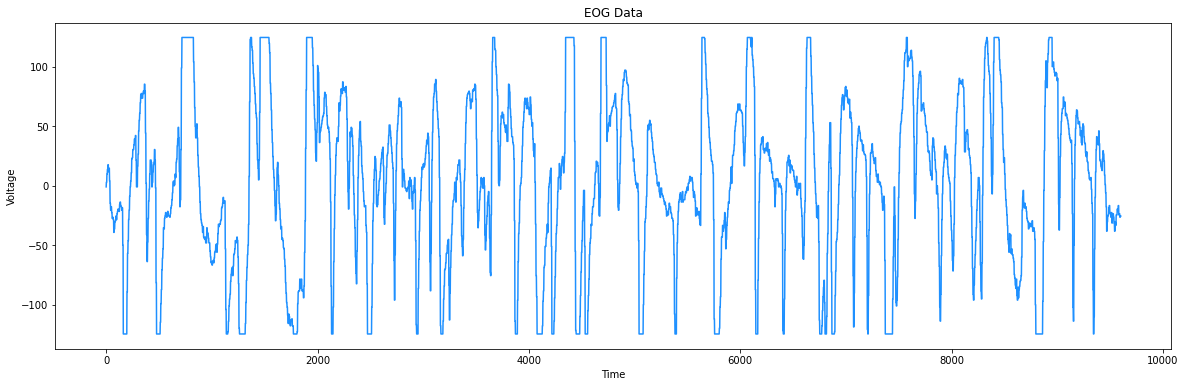

In [131]:
EOG_data = EOG_data.astype(np.float64)

plt.plot(EOG_data, color='dodgerblue', label='EOG Data')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.title('EOG Data')

plt.show()

You should notice that some points in the plot have flat tops or bottoms. Medically, this is not reflecting reality. The flat tops and bottoms are simply clipping regions, since the measurement value exceeded the measurement range of a floating point number. We can locate these regions for visualization.

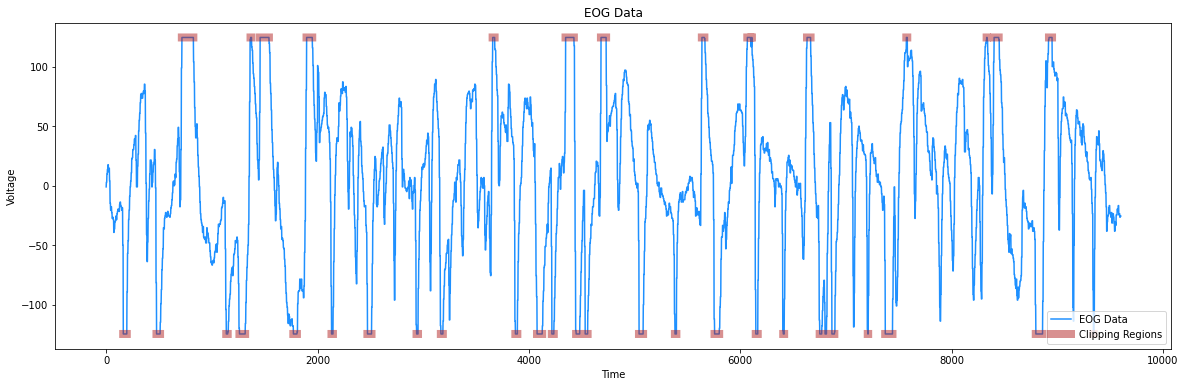

In [132]:
overflow_val = np.amax(EOG_data)
underflow_val = np.amin(EOG_data)

flat_values = np.zeros(len(EOG_data))
for i in range(len(EOG_data)):
    if EOG_data[i] == overflow_val or EOG_data[i] == underflow_val:
        flat_values[i] = EOG_data[i]
    else:
        flat_values[i] = np.nan

plt.plot(EOG_data, color='dodgerblue', label='EOG Data')
plt.plot(flat_values, color='firebrick', alpha=0.5, linewidth=8, label='Clipping Regions')
plt.legend(loc ='lower right')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.title('EOG Data')

plt.show()

We can compute the matrix profile and locate the best motifs.

In [133]:
window_size = 450
matrix_profile = stump(EOG_data, window_size)
motif1, motif2 = getMotifData(EOG_data, matrix_profile, window_size)

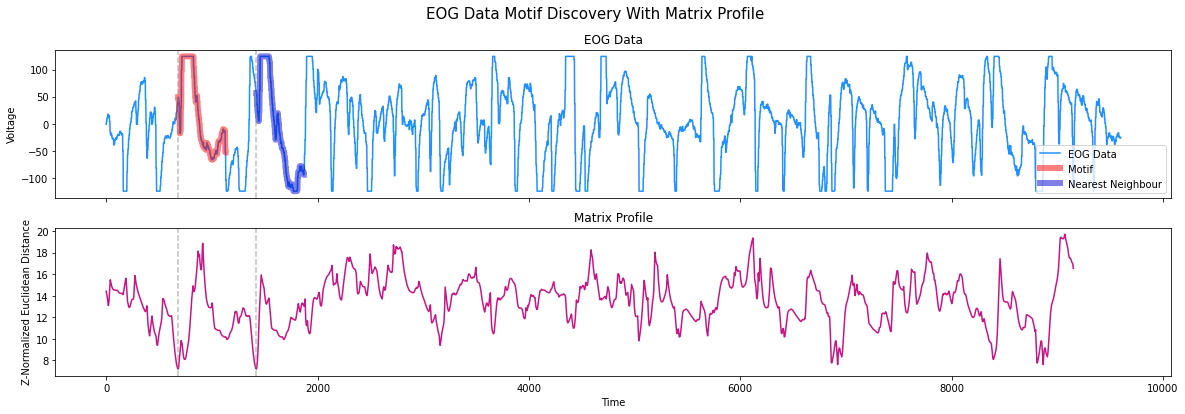

In [134]:
fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('EOG Data Motif Discovery With Matrix Profile', fontsize='15')

axis[0].plot(EOG_data, color='dodgerblue', label='EOG Data')
axis[0].plot(motif1[1], motif1[2], color='red', linewidth=6, alpha=0.5, label='Motif')
axis[0].plot(motif2[1], motif2[2], color='mediumblue', linewidth=6, alpha=0.5, label='Nearest Neighbour')
axis[0].legend()
axis[0].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[0].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[0].set_ylabel('Voltage')
axis[0].set_title('EOG Data')

axis[1].plot(matrix_profile[:, 0], color='mediumvioletred', label='Matrix Profile')
axis[1].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[1].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Z-Normalized Euclidean Distance')
axis[1].set_title('Matrix Profile')

plt.show()

Unsurprisingly, the nearest neighbors contain the biggest flat top of the time series. This makes sense, since the z-normalized Euclidean distance between two flat tops is very low.

Of course, because the flat tops or bottoms are areas where the actual value of the EOG is unclear, we want to make this a less desirable motif. But the difference between the previous case with the fNIRS data and this is that, with the EOG data we don't want to completely dismiss the clipping regions. Rather, we want to slightly penalize them.

We do this by constructing an annotation vector that is real-valued, as opposed to the previous example where it could only be 0 or 1. For every subsequence, we count the number of values that are equal to the global minimum or maximum. The more that number is, the lower we set the annotation vector value for that subsequence, and vice versa.

In [135]:
annotation_vector = np.zeros(len(EOG_data) - window_size + 1)

for i in range(len(EOG_data) - window_size + 1):
    window = EOG_data[i:i + window_size]
    annotation_vector[i] = np.count_nonzero(window == overflow_val) + np.count_nonzero(window == underflow_val)
    
annotation_vector = annotation_vector - np.amin(annotation_vector)
annotation_vector = annotation_vector / np.amax(annotation_vector)
annotation_vector = 1 - annotation_vector

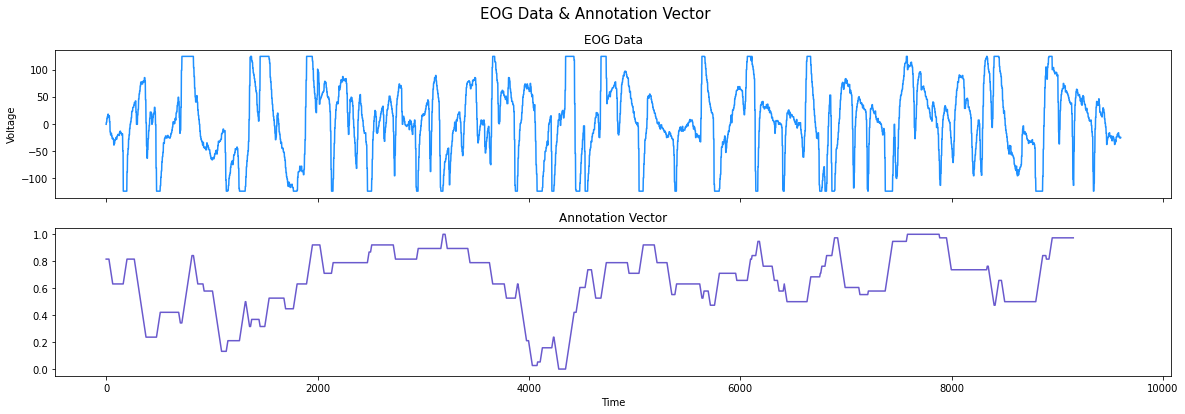

In [136]:
fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('EOG Data & Annotation Vector', fontsize='15')

axis[0].plot(EOG_data, color='dodgerblue', label='EOG Data')
axis[0].set_ylabel('Voltage')
axis[0].set_title('EOG Data')

axis[1].plot(annotation_vector, color='slateblue', label='Annotation Vector')
axis[1].set_xlabel('Time')
axis[1].set_title('Annotation Vector')

plt.show()

Now we have an annotation vector that is lower at subsequences that contain flat tops or bottoms, and higher where there are no flat tops or bottoms. We use this to generate the corrected matrix profile.

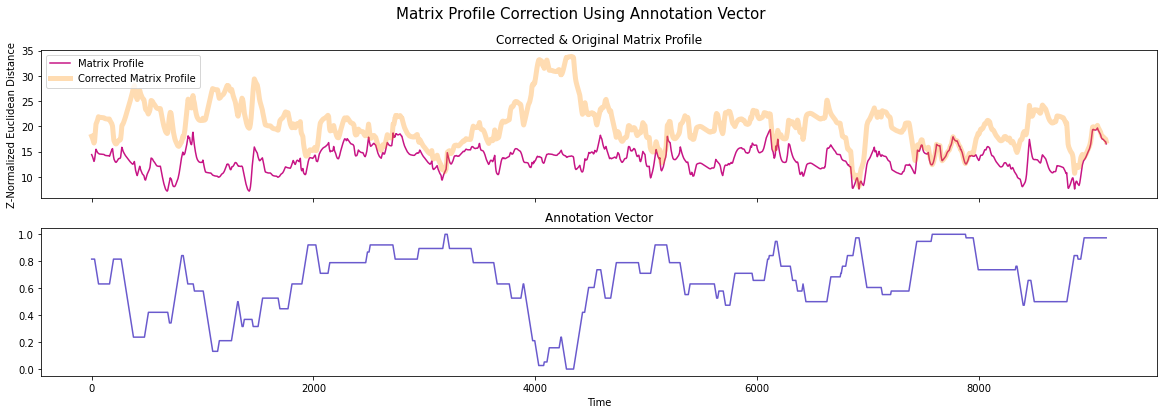

In [137]:
corrected_matrix_profile = matrix_profile[:, 0] + ((1 - annotation_vector) * np.amax(matrix_profile[:, 0]))
corrected_matrix_profile = np.column_stack((corrected_matrix_profile, matrix_profile[:, [1, 2, 3]]))
motif1, motif2 = getMotifData(EOG_data, corrected_matrix_profile, window_size)

fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('Matrix Profile Correction Using Annotation Vector', fontsize='15')

axis[0].plot(matrix_profile[:, 0], color='mediumvioletred', label='Matrix Profile')
axis[0].plot(corrected_matrix_profile[:, 0], color='darkorange', linewidth=5, alpha=0.3, label='Corrected Matrix Profile')
axis[0].set_ylabel('Z-Normalized Euclidean Distance')
axis[0].set_title('Corrected & Original Matrix Profile')
axis[0].legend(loc ='upper left')

axis[1].plot(annotation_vector, color='slateblue', label='Annotation Vector')
axis[1].set_xlabel('Time')
axis[1].set_title('Annotation Vector')

plt.show()

Clearly, the subsequences with the lowest distance value has changed. Now we compute the motifs again.

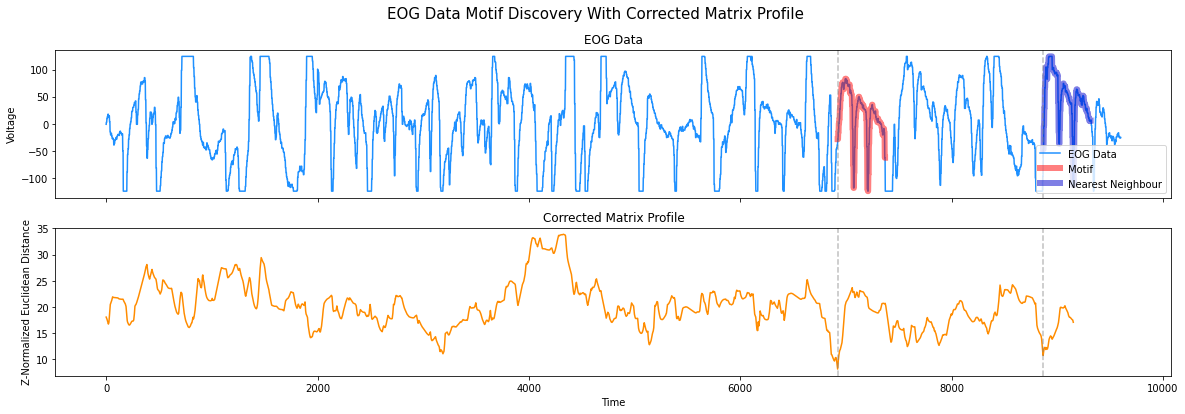

In [138]:
fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('EOG Data Motif Discovery With Corrected Matrix Profile', fontsize='15')

axis[0].plot(EOG_data, color='dodgerblue', label='EOG Data')
axis[0].plot(motif1[1], motif1[2], color='red', linewidth=6, alpha=0.5, label='Motif')
axis[0].plot(motif2[1], motif2[2], color='mediumblue', linewidth=6, alpha=0.5, label='Nearest Neighbour')
axis[0].legend()
axis[0].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[0].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[0].set_ylabel('Voltage')
axis[0].set_title('EOG Data')

axis[1].plot(corrected_matrix_profile[:, 0], color='darkorange', label='Corrected Matrix Profile')
axis[1].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[1].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Z-Normalized Euclidean Distance')
axis[1].set_title('Corrected Matrix Profile')

plt.show()

As we can see, the new motifs are no longer at flat top or bottom regions. Once again, we've redirected the algorithm to find more interesting motifs.

## Summary

And that's it! You've now learnt the basics of guided motif search and annotation vectors, and the use of annotation vectors in solving simple cases of time series motif search biases. In the second part of this series, [Advanced Annotation Vectors](https://stumpy.readthedocs.io/en/latest/Tutorial_Advanced_Annotation_Vectors.html), we will learn about two more complex types of biases and explore the methods of dealing with them using annotation vectors.

## Resources

[Matrix Profile I](https://www.cs.ucr.edu/~eamonn/PID4481997_extend_Matrix%20Profile_I.pdf)

[STUMPY Basics](https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html)

[Matrix Profile V](https://www.cs.ucr.edu/~eamonn/guided-motif-KDD17-new-format-10-pages-v005.pdf)

[Advanced Annotation Vectors](https://stumpy.readthedocs.io/en/latest/Tutorial_Advanced_Annotation_Vectors.html)